# S13 WESAD XGBoost  

    Male Participant
    Age: 28
    Height (cm): 181
    Weight (kg): 82

# Load Tools

In [2]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.utils import class_weight
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier

In [4]:
# Visualizing High-Performance Gradient Boosting with XGBoost and Yellowbrick
# https://rebeccabilbro.github.io/xgboost-and-yellowbrick/
# conda install -c districtdatalabs yellowbrick

from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

In [5]:
sns.set(style="darkgrid")

In [6]:
# https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed#:~:text=Colors%3A%20Use%20this%20code%3A%20%3C,space%2C%20then%20type%20the%20text.
# https://www.w3schools.com/charsets/ref_utf_geometric.asp# import pydot

In [7]:
import autoreload
%load_ext watermark
%load_ext autoreload
%autoreload 2
%watermark -a 'WForsythe' -d -t -v -p   numpy,pandas,cv2,xgboost,sklearn,seaborn,matplotlib,yellowbrick

WForsythe 2020-07-29 14:47:35 

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
pandas 1.0.3
cv2 4.2.0
xgboost 1.0.2
sklearn 0.22.1
seaborn 0.9.0
matplotlib 3.2.2
yellowbrick 1.1


# Load and Process File

## Load File

In [7]:
%%time
data = 'D:/WESAD/'
s13_file = pd.read_pickle(data + 'S13/S13.pkl')
s13_file

Wall time: 10.4 s


{'signal': {'chest': {'ACC': array([[ 0.97259998, -0.14120001,  0.23179996],
          [ 0.99100006, -0.08279997,  0.20780003],
          [ 0.99779999, -0.023     ,  0.02380002],
          ...,
          [ 0.93420005,  0.09459996, -0.12019998],
          [ 0.93700004,  0.10099995, -0.1128    ],
          [ 0.9382    ,  0.10220003, -0.11299998]]),
   'ECG': array([[-0.27278137],
          [-0.27104187],
          [-0.26394653],
          ...,
          [-0.15142822],
          [-0.15769958],
          [-0.15934753]]),
   'EMG': array([[-0.00498962],
          [-0.04788208],
          [-0.06752014],
          ...,
          [-0.00485229],
          [ 0.00801086],
          [ 0.00068665]]),
   'EDA': array([[2.34718323],
          [2.36778259],
          [2.35862732],
          ...,
          [3.52859497],
          [3.51676941],
          [3.52897644]]),
   'Temp': array([[32.62726 ],
          [32.622772],
          [32.621246],
          ...,
          [34.167206],
          [34.159607

## Process

### Separate chest features  from wrist  features 

In [8]:
cax = s13_file['signal']['chest']['ACC'][0:,0]
cay = s13_file['signal']['chest']['ACC'][0:,1]
caz = s13_file['signal']['chest']['ACC'][0:,2]
cecg = s13_file['signal']['chest']['ECG'][:,0]
cemg = s13_file['signal']['chest']['EMG'][:,0]
ceda = s13_file['signal']['chest']['EDA'][:,0]
ctemp = s13_file['signal']['chest']['Temp'][:,0]
cresp = s13_file['signal']['chest']['Resp'][:,0]
label = s13_file['label']

In [9]:
label

array([0, 0, 0, ..., 0, 0, 0])

### Change dictionary object to a numpy array and array to a dataframe

In [9]:
# Python | Numpy ndarray.T
# https://www.geeksforgeeks.org/python-numpy-ndarray-t/
# Numpy Array Cookbook: Generating and Manipulating Arrays in Python
# https://towardsdatascience.com/numpy-array-cookbook-generating-and-manipulating-arrays-in-python-2195c3988b09

In [10]:
chest = [cax, cay, caz, cecg, cemg, 
         ceda, ctemp, cresp, label] 
ch_array = np.array(chest) 
ch_array = ch_array.T # transpose 
Columns = ['cax', 'cay', 'caz','cecg', 'cemg', 
          'ceda','ctemp', 'cresp', 'label' ]
ch_df = pd.DataFrame(ch_array, columns = Columns) 
ch_df

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.9726,-0.1412,0.2318,-0.272781,-0.004990,2.347183,32.627258,0.050354,0.0
1,0.9910,-0.0828,0.2078,-0.271042,-0.047882,2.367783,32.622772,0.404358,0.0
2,0.9978,-0.0230,0.0238,-0.263947,-0.067520,2.358627,32.621246,0.405884,0.0
3,1.0114,0.0406,-0.2766,-0.255386,-0.041428,2.349091,32.603302,0.404358,0.0
4,1.0318,0.0842,-0.4152,-0.261520,0.006638,2.359009,32.624237,0.396729,0.0
...,...,...,...,...,...,...,...,...,...
3875895,0.9288,0.0906,-0.1214,-0.120529,-0.020828,3.525162,34.109283,-0.611877,0.0
3875896,0.9310,0.0920,-0.1186,-0.136734,-0.006042,3.516769,34.168732,-0.517273,0.0
3875897,0.9342,0.0946,-0.1202,-0.151428,-0.004852,3.528595,34.167206,-0.517273,0.0
3875898,0.9370,0.1010,-0.1128,-0.157700,0.008011,3.516769,34.159607,-0.617981,0.0


#### Check Statistics

In [11]:
ch_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,3875900.0,0.871506,0.053724,0.250600,0.845200,0.877800,0.908200,2.841800
cay,3875900.0,-0.026478,0.094199,-0.549800,-0.062600,-0.039000,0.015800,0.519800
caz,3875900.0,-0.160541,0.233431,-0.897400,-0.349400,-0.186600,0.012600,0.911400
cecg,3875900.0,0.001111,0.234763,-1.050156,-0.090408,-0.043259,0.022476,1.499954
cemg,3875900.0,-0.003054,0.013728,-0.286514,-0.010025,-0.002701,0.003891,0.463852
ceda,3875900.0,3.168534,0.765021,2.026749,2.454758,3.025818,3.544617,6.635284
ctemp,3875900.0,34.025030,0.374422,32.530121,33.937256,34.129089,34.234375,34.864685
cresp,3875900.0,0.050309,4.927053,-30.082703,-2.389526,-0.257874,2.465820,37.886047
label,3875900.0,1.355788,1.575795,0.000000,0.000000,1.000000,2.000000,7.000000


#### Check Type

In [12]:
print(ch_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3875900 entries, 0 to 3875899
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cax     float64
 1   cay     float64
 2   caz     float64
 3   cecg    float64
 4   cemg    float64
 5   ceda    float64
 6   ctemp   float64
 7   cresp   float64
 8   label   float64
dtypes: float64(9)
memory usage: 266.1 MB
None


### Concatenate classes 0, 1, 2, 3, and 4
    Classes 5, 6 and 7 correspond to timed periods in which the participant answered questionnaires, 
    therefore, only classes 0, 1, 2, 3, and 4 will be used 
    Additionally, the significant imbalance has been eliminated

In [14]:
loc0 = ch_df.loc[ch_df['label'] == 0]
loc1 = ch_df.loc[ch_df['label'] == 1]
loc2 = ch_df.loc[ch_df['label'] == 2]
loc3 = ch_df.loc[ch_df['label'] == 3]
loc4 = ch_df.loc[ch_df['label'] == 4]

In [15]:
ch_loc = pd.concat([loc0, loc1, loc2, loc3, loc4])
ch_loc

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.9726,-0.1412,0.2318,-0.272781,-0.004990,2.347183,32.627258,0.050354,0.0
1,0.9910,-0.0828,0.2078,-0.271042,-0.047882,2.367783,32.622772,0.404358,0.0
2,0.9978,-0.0230,0.0238,-0.263947,-0.067520,2.358627,32.621246,0.405884,0.0
3,1.0114,0.0406,-0.2766,-0.255386,-0.041428,2.349091,32.603302,0.404358,0.0
4,1.0318,0.0842,-0.4152,-0.261520,0.006638,2.359009,32.624237,0.396729,0.0
...,...,...,...,...,...,...,...,...,...
3741430,0.8244,-0.0766,-0.4402,0.019638,-0.002884,3.594971,34.249634,0.059509,4.0
3741431,0.8240,-0.0744,-0.4366,0.023849,-0.017441,3.611374,34.280182,0.032043,4.0
3741432,0.8226,-0.0748,-0.4358,0.033737,-0.002701,3.586578,34.280182,0.067139,4.0
3741433,0.8238,-0.0764,-0.4370,0.046829,-0.009933,3.599167,34.274109,0.035095,4.0


#### Check Statistics

In [16]:
ch_loc.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,3794000.0,0.870688,0.053984,0.250600,0.844600,0.876000,0.908000,2.841800
cay,3794000.0,-0.026806,0.095158,-0.549800,-0.064000,-0.040000,0.017400,0.519800
caz,3794000.0,-0.165206,0.233411,-0.897400,-0.351400,-0.193400,0.007400,0.911400
cecg,3794000.0,0.001114,0.234874,-1.050156,-0.090408,-0.043076,0.022385,1.499954
cemg,3794000.0,-0.003056,0.013785,-0.286514,-0.010025,-0.002701,0.003891,0.463852
ceda,3794000.0,3.172072,0.768966,2.026749,2.456284,3.026962,3.541946,6.635284
ctemp,3794000.0,34.021846,0.375761,32.530121,33.944855,34.129089,34.231323,34.864685
cresp,3794000.0,0.046755,4.921680,-30.082703,-2.372742,-0.247192,2.479553,37.886047
label,3794000.0,1.260885,1.448826,0.000000,0.000000,1.000000,2.000000,4.000000


#### Plot all classes vs. classes 0,1,2,3,4 

3875900 3794000
Number of Rows Removed: 81900


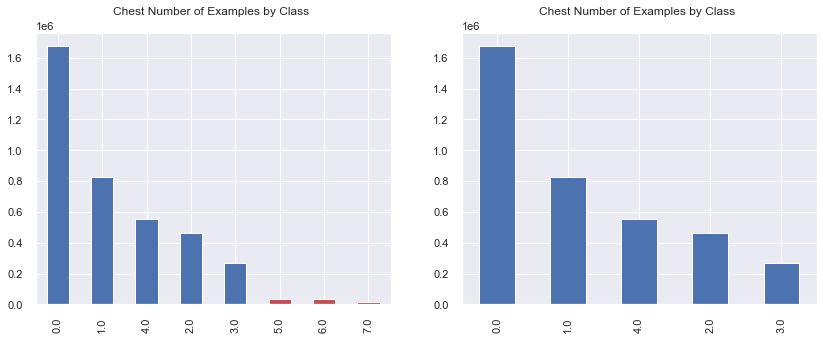

In [17]:
plt.figure(figsize = (14,5))
plt.subplot(1, 2, 1)
ch_df['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n',
                                     color=['b','b','b','b','b','r','r','r'])
plt.subplot(1, 2, 2)
ch_loc['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n')
print((ch_df['label'].value_counts().sum()), ch_loc['label'].value_counts().sum())
print('Number of Rows Removed:', (ch_df['label'].value_counts().sum()) - 
      ch_loc['label'].value_counts().sum());

**XGBoost for Multi-class Classification** <br>
https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

In [24]:
# Multiclass ROC AUC Score original script sourced from 
'''
Author: Plog, E
Title: AUC ROC Curve Scoring Function for Multi-class Classification
Date: 2018
Code version: n.a.
Availability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
'''

'\nAuthor: Plog, E\nTitle: AUC ROC Curve Scoring Function for Multi-class Classification\nDate: 2018\nCode version: n.a.\nAvailability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659\n'

# Model Runs: XGBoost Classifier

## Model allChest: All chest features

### Train Test

In [20]:
y = ch_loc.label
x = ch_loc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)
evalSet = [(x_train, y_train), (x_test, y_test)]

(3035200, 8)
(758800,)


### Check Correlations

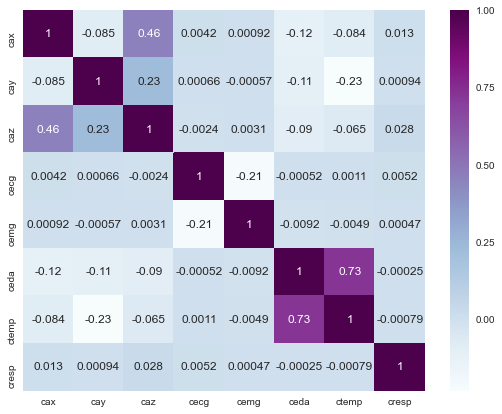

In [21]:
plt.figure(figsize=(9,7))
sns.heatmap(x_train.corr(), annot=True, cmap=plt.cm.BuPu);

    There is a strong correlation between temp and eda 

### Model Fit and f1 and Balanced Accuracy Scores

In [22]:
%%time
allChest = xgb.XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 300, 
                              max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              seed = 24,
                              verbosity = 2) 

model_allChest = allChest.fit(x_train,y_train, 
                              eval_metric=['merror'],
                              eval_set = evalSet) 
allChest_pred = allChest.predict(x_test)
allChest_report = (classification_report(y_test,
                                         allChest_pred,
                                         labels=np.unique(allChest_pred),
                                         digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, allChest_pred))
print('----------------------------------------')
print('------------ S11 All Chest Classification Report------------')
print(allChest_report)

[0]	validation_0-merror:0.01581	validation_1-merror:0.01591
[1]	validation_0-merror:0.01542	validation_1-merror:0.01556
[2]	validation_0-merror:0.01551	validation_1-merror:0.01559
[3]	validation_0-merror:0.01535	validation_1-merror:0.01540
[4]	validation_0-merror:0.01514	validation_1-merror:0.01524
[5]	validation_0-merror:0.01498	validation_1-merror:0.01508
[6]	validation_0-merror:0.01487	validation_1-merror:0.01499
[7]	validation_0-merror:0.01470	validation_1-merror:0.01482
[8]	validation_0-merror:0.01438	validation_1-merror:0.01458
[9]	validation_0-merror:0.01417	validation_1-merror:0.01440
[10]	validation_0-merror:0.01371	validation_1-merror:0.01394
[11]	validation_0-merror:0.01352	validation_1-merror:0.01377
[12]	validation_0-merror:0.01325	validation_1-merror:0.01355
[13]	validation_0-merror:0.01311	validation_1-merror:0.01339
[14]	validation_0-merror:0.01290	validation_1-merror:0.01321
[15]	validation_0-merror:0.01273	validation_1-merror:0.01301
[16]	validation_0-merror:0.01260	v

[134]	validation_0-merror:0.00564	validation_1-merror:0.00642
[135]	validation_0-merror:0.00563	validation_1-merror:0.00640
[136]	validation_0-merror:0.00562	validation_1-merror:0.00641
[137]	validation_0-merror:0.00561	validation_1-merror:0.00639
[138]	validation_0-merror:0.00560	validation_1-merror:0.00638
[139]	validation_0-merror:0.00560	validation_1-merror:0.00638
[140]	validation_0-merror:0.00560	validation_1-merror:0.00638
[141]	validation_0-merror:0.00559	validation_1-merror:0.00636
[142]	validation_0-merror:0.00559	validation_1-merror:0.00637
[143]	validation_0-merror:0.00559	validation_1-merror:0.00637
[144]	validation_0-merror:0.00559	validation_1-merror:0.00637
[145]	validation_0-merror:0.00559	validation_1-merror:0.00637
[146]	validation_0-merror:0.00559	validation_1-merror:0.00637
[147]	validation_0-merror:0.00559	validation_1-merror:0.00637
[148]	validation_0-merror:0.00559	validation_1-merror:0.00637
[149]	validation_0-merror:0.00559	validation_1-merror:0.00637
[150]	va

[267]	validation_0-merror:0.00558	validation_1-merror:0.00636
[268]	validation_0-merror:0.00558	validation_1-merror:0.00636
[269]	validation_0-merror:0.00558	validation_1-merror:0.00636
[270]	validation_0-merror:0.00558	validation_1-merror:0.00636
[271]	validation_0-merror:0.00558	validation_1-merror:0.00636
[272]	validation_0-merror:0.00558	validation_1-merror:0.00636
[273]	validation_0-merror:0.00558	validation_1-merror:0.00636
[274]	validation_0-merror:0.00558	validation_1-merror:0.00636
[275]	validation_0-merror:0.00558	validation_1-merror:0.00636
[276]	validation_0-merror:0.00558	validation_1-merror:0.00636
[277]	validation_0-merror:0.00558	validation_1-merror:0.00636
[278]	validation_0-merror:0.00558	validation_1-merror:0.00636
[279]	validation_0-merror:0.00558	validation_1-merror:0.00636
[280]	validation_0-merror:0.00558	validation_1-merror:0.00636
[281]	validation_0-merror:0.00558	validation_1-merror:0.00636
[282]	validation_0-merror:0.00558	validation_1-merror:0.00636
[283]	va

### Confusion Matrix

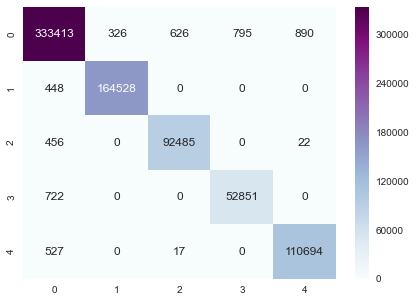

In [23]:
cm = confusion_matrix(y_test, allChest_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Multi-class AUC Score

In [26]:
def multiclass_roc_auc_score(y_test, allChest_pred, average = 'micro'): 
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(allChest_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, allChest_pred)

print('S11 All Chest')
print('---------------------')
print("AUC: %.2f%%" % (aucScore*100))

S11 All Chest
---------------------
AUC: 99.60%


## Model ch_lessAcc: Chest Less Accelerometer  

### Train Test Split

In [33]:
lessAcc = ch_loc[['ceda', 'ctemp', 'cresp', 'cemg', 'cecg', 'label']]
y = lessAcc.label
x = lessAcc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(3035200, 5)
(758800,)


### Model Fit and f1 and Balanced Accuracy Scores

In [34]:
%%time
ch_lessAcc = XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 200, 
                              max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              #seed = 24,
                              verbosity = 2) 

model_ch_lessAcc = ch_lessAcc.fit(x_train,y_train)
ch_lessAcc_pred = ch_lessAcc.predict(x_test)
ch_lessAcc_report = (classification_report(y_test,
                                           ch_lessAcc_pred,
                                           labels=np.unique(ch_lessAcc_pred),
                                           digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, ch_lessAcc_pred))
print('----------------------------------------')
print('------------ S11 All Chest less ACC Classification Report------------')
print(ch_lessAcc_report)

Balanced Accuracy: 0.9292336474658827
----------------------------------------
------------ S11 All Chest less ACC Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9153    0.9511    0.9328    335770
         1.0     0.9925    0.9908    0.9917    165423
         2.0     0.9776    0.9478    0.9624     92851
         3.0     0.9474    0.9360    0.9417     53722
         4.0     0.8961    0.8205    0.8566    111034

    accuracy                         0.9392    758800
   macro avg     0.9458    0.9292    0.9370    758800
weighted avg     0.9392    0.9392    0.9388    758800

Wall time: 55.8 s


### Confusion Matrix

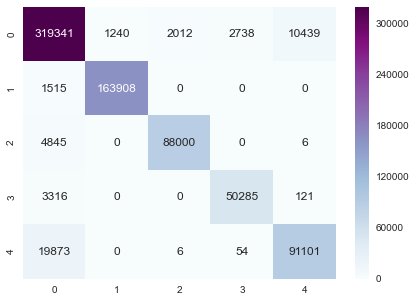

In [35]:
cm = confusion_matrix(y_test, ch_lessAcc_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Classification Prediction Error

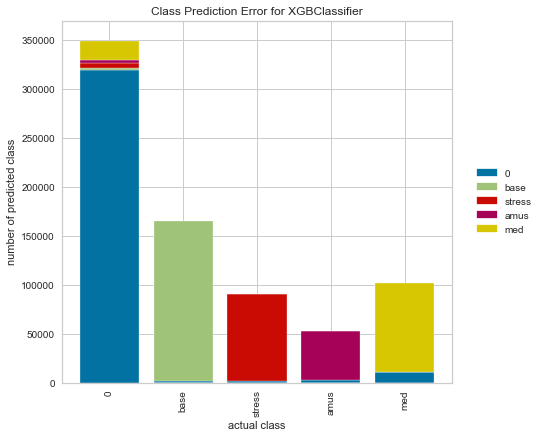

In [36]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(ch_lessAcc, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

### Multiclass ROC AUC Score

In [37]:
def multiclass_roc_auc_score(y_test, ch_lessAcc_pred, average = 'micro'): 
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(ch_lessAcc_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, ch_lessAcc_pred)

print('S11 All Chest less ACC')
print('-------------------------------')
print("AUC: %.2f%%" % (aucScore*100))

S11 All Chest less ACC
-------------------------------
AUC: 96.20%


##  Model ACC: Accelerometer [X,Y,Z]

### Train Test Split

In [38]:
ch_ACC = ch_loc[['cax', 'cay', 'caz', 'label']]
y = ch_ACC.label
x = ch_ACC.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(3035200, 3)
(758800,)


### Model Fit and f1 and Balanced Accuracy Scores

In [39]:
%%time
ACC = XGBClassifier(objective = 'multi:softmax',
                    tree_method = 'gpu_hist',
                    learning_rate = 0.1,
                    gradient_based = 0.1,
                    max_depth = 10,
                    num_early_stopping_rounds = 20,
                    n_estimators = 300,
                    gamma = 3,
                    verbosity = 2) 

model_ACC = ACC.fit(x_train, y_train)
ACC_pred = ACC.predict(x_test)
ACC_report = (classification_report(y_test,
                                    ACC_pred,
                                    labels=np.unique(ACC_pred),
                                    digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, ACC_pred))
print('---------------------------------------')
print('------------ S11 Chest ACC Classification Report------------')
print(ACC_report)

Balanced Accuracy: 0.7831199928579576
---------------------------------------
------------ S11 Chest ACC Classification Report------------
              precision    recall  f1-score   support

         0.0     0.8522    0.8559    0.8540    336067
         1.0     0.8681    0.8064    0.8361    164775
         2.0     0.6643    0.6811    0.6726     93043
         3.0     0.7466    0.6454    0.6923     53661
         4.0     0.8156    0.9268    0.8676    111254

    accuracy                         0.8192    758800
   macro avg     0.7894    0.7831    0.7845    758800
weighted avg     0.8198    0.8192    0.8185    758800

Wall time: 58.1 s


### Confusion matrix 

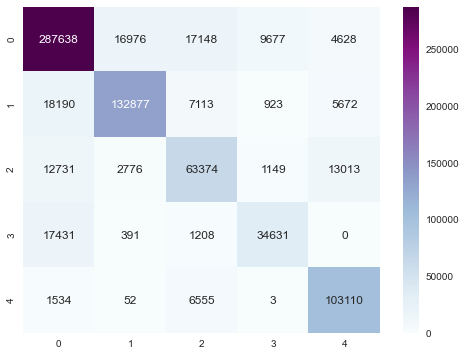

In [40]:
cm = confusion_matrix(y_test, ACC_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Classification Prediction Error

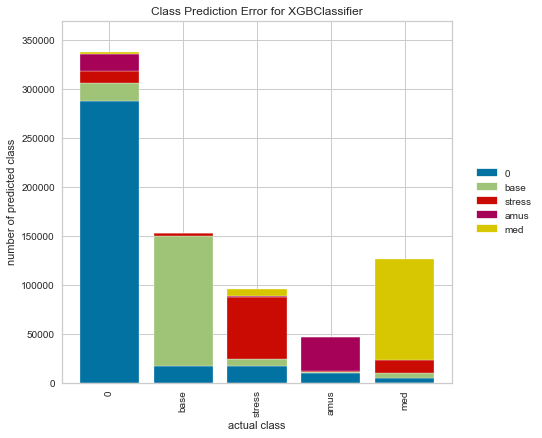

In [41]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(ACC, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

### Multiclass ROC AUC Score

In [42]:
def multiclass_roc_auc_score(y_test, ACC_pred, average = 'macro'): #(None, 'micro', 'macro', 'weighted', 'samples')
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(ACC_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, ACC_pred)

print('S11 Chest Accelerometer')
print('-------------------')
print("AUC: %.2f%%" % (aucScore*100))  

S11 Chest Accelerometer
-------------------
AUC: 86.63%


## Model Eda: Electrodermal Activity only

In [18]:
ch_eda= ch_loc[['ceda', 'label']]
y = ch_eda.label
x = ch_eda.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(3035200, 1)
(758800,)


In [19]:
%%time
Eda = XGBClassifier(objective = 'multi:softmax',
                    tree_method = 'gpu_hist',
                    learning_rate = 0.1,
                    gradient_based = 0.1,
                    num_early_stopping_rounds = 20,
                    n_estimators = 300,
                    max_depth = 10,
                    gamma = 3,
                    seed = 24,
                    verbosity = 2) 

model_Eda = Eda.fit(x_train, y_train)
Eda_pred = Eda.predict(x_test)
Eda_report = (classification_report(y_test,
                                    Eda_pred,
                                    labels = np.unique(Eda_pred),
                                    digits = 4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, Eda_pred))
print('---------------------------------------')
print('------------ S11 Chest Electrodermal Activity Classification Report------------')
print(Eda_report)

Balanced Accuracy: 0.834649609024584
---------------------------------------
------------ S11 Chest Electrodermal Activity Classification Report------------
              precision    recall  f1-score   support

         0.0     0.8066    0.9110    0.8556    336213
         1.0     0.9294    0.9923    0.9598    164999
         2.0     0.9839    0.8554    0.9151     93068
         3.0     0.9047    0.9072    0.9059     53645
         4.0     0.8247    0.5074    0.6283    110875

    accuracy                         0.8626    758800
   macro avg     0.8899    0.8346    0.8530    758800
weighted avg     0.8646    0.8626    0.8559    758800

Wall time: 1min 4s


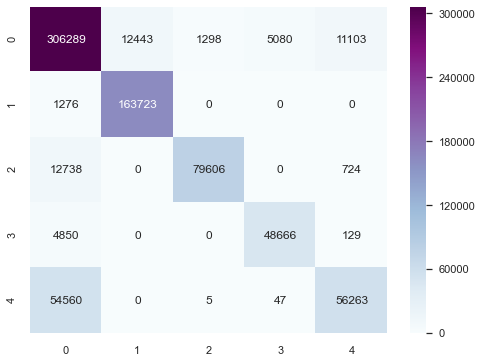

In [20]:
cm = confusion_matrix(y_test, Eda_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

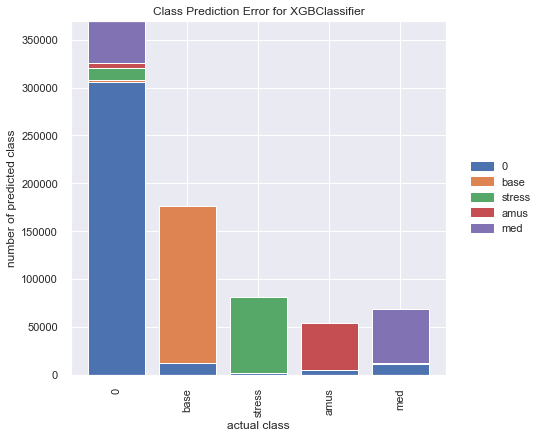

In [21]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(Eda, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

In [22]:
def multiclass_roc_auc_score(y_test, Eda_pred, average = 'macro'): #(None, 'micro', 'macro', 'weighted', 'samples')
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(Eda_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, Eda_pred)

print('S11 Chest Skin Temperature')
print('-------------------')
print("AUC: %.2f%%" % (aucScore*100))  

S11 Chest Skin Temperature
-------------------
AUC: 89.51%
